In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

from sklearn.linear_model import LogisticRegression

## Data Processing

In [87]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

id                                            subject  \
0   0  Subject: A&L Daily to be auctioned in bankrupt...   
1   1  Subject: Wired: "Stronger ties between ISPs an...   
2   2  Subject: It's just too small                  ...   
3   3                      Subject: liberal defnitions\n   
4   4  Subject: RE: [ILUG] Newbie seeks advice - Suse...   

                                               email  spam  
0  url: http://boingboing.net/#85534171\n date: n...     0  
1  url: http://scriptingnews.userland.com/backiss...     0  
2  <html>\n <head>\n </head>\n <body>\n <font siz...     1  
3  depends on how much over spending vs. how much...     0  
4  hehe sorry but if you hit caps lock twice the ...     0

In [88]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


In [89]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop = True)

## Some Experimentation

First, I make a function that will be useful for my logistic regression model! words_in_texts creates a 2D array that helps us identify whether certain words occur in certain texts. This is similar to OHE!

In [90]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

Below is an example of the model I want to construct with some random words to classify an email as spam or ham.

In [91]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7570877146279782


To find words that will be effective at differentiating between spam and ham emails, we can play around with different words and observe which ones have the highest difference in occurence. This is visualized below.

Text(0, 0.5, 'statistic')

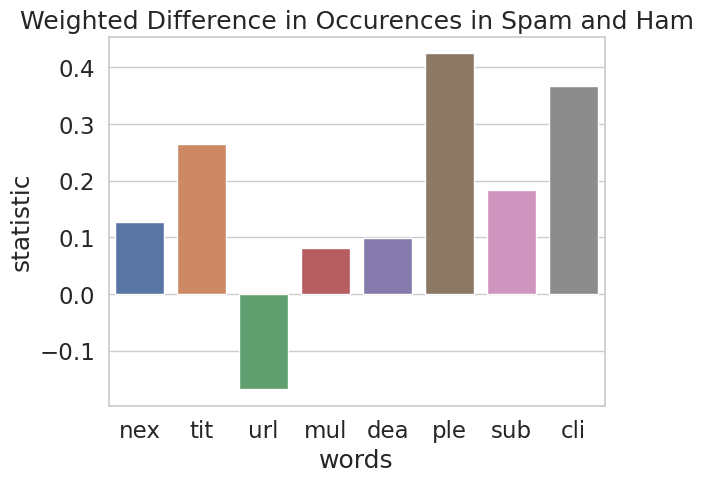

In [92]:
words = ['nextpart', 'title', 'url', 'multi-part', 'dear', 'please', 'subject', 'click', 'miracle', 'suspect', 'increase', 'giveaway', '\n', '_', "!", '<br>', '<html>']

#Determines the difference in occurences in spam vs ham, weighted by totals of each
num_spam = sum(train["spam"])
num_ham = len(train["spam"]) - num_spam

def statistic(word):
    return sum(train["email"].str.contains(word) & train["spam"])/num_spam - sum(train["email"].str.contains(word) & ~train["spam"])/num_ham

w = pd.Series(words[:8])
y = "Weighted Difference in Occurences in Spam and Ham"
frame = {"words": w.str[0:3], y: np.vectorize(statistic)(w)}
data = pd.DataFrame(frame)
sns.barplot(data=data, x="words", y=y)
plt.title(y)
plt.ylabel("statistic")

Finally, we can use the words we chose to construct a spam email filter! First, I construct a Logistic Regression model with threshold 0.5.

In [93]:
X_train = words_in_texts(words, train["email"])
Y_train = np.array(train["spam"])

model = LogisticRegression(fit_intercept = True)
model.fit(X_train, Y_train)

def process(data):
    X = words_in_texts(words, data["email"])
    return X

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

validation_accuracy = model.score(process(val), np.array(val["spam"]))
print("Validation Accuracy: ", validation_accuracy)

Training Accuracy:  0.885531744975376
Validation Accuracy:  0.858682634730539


Now we tune the threshold for the logistic regression model. Our goal is to accurately predict 95%+ of ham emails while filtering at least 50% of spam emails. This way, we don't lose too many real emails, but we are able to filter a reasonable chunk of spam!

In [94]:
spamProb = model.predict_proba(X_train)[:, 1]

def spamacc_and_hamacc(threshold):
    pred = spamProb>threshold
    TP = sum(pred & Y_train)
    FP = sum(pred & ~Y_train)
    FN = sum(~pred & Y_train)
    TN = sum(~pred & ~Y_train)
    return TP/(TP+FN), TN/(TN+FP)

Text(0.5, 1.0, 'Spam and Ham Accuracy Curves')

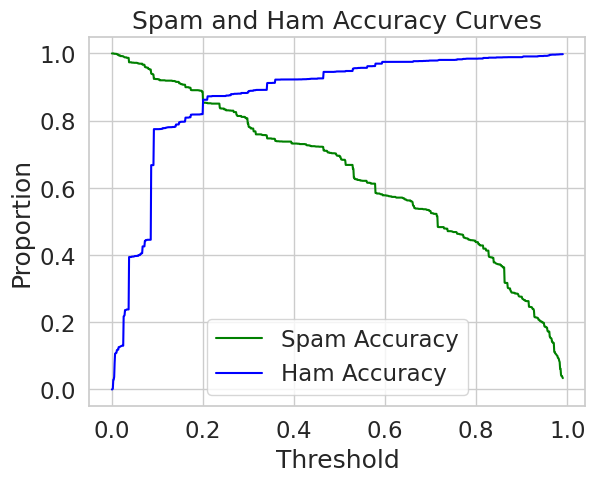

In [80]:
bins = np.linspace(0, 0.99, num=1000)
yp, yr = np.vectorize(spamacc_and_hamacc)(bins)
plt.plot(bins, yp, color="green", label="Spam Accuracy")
plt.plot(bins, yr, color="blue", label="Ham Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Proportion")
plt.legend()
plt.title("Spam and Ham Accuracy Curves")

From the plot above, a threshold of around 0.7 best accomplishes our goal of retaining 95%+ of ham emails while filtering at least 50% of spam! Finally, we can create our spamEmailPredictor function!

In [83]:
ideal_threshold = 0.7

def spamEmailPredictor(data):
    return model.predict_proba(process(data))[:, 1] > ideal_threshold

Applying spamEmailPredictor to our validation set yields an accuracy of 85.0%! This isn't much less than with our original threshold. However, now, 97.7% of ham emails are being classified correctly, and 51.1% of spam emails are still being filtered!

In [98]:
prediction = spamEmailPredictor(val)
reality = np.array(val["spam"])

TP = sum(prediction & reality)
FP = sum(prediction & ~reality)
FN = sum(~prediction & reality)
TN = sum(~prediction & ~reality)

print("Accuracy:", np.mean(prediction==reality))
print("Ham Accuracy:", TN/(TN+FP))
print("Spam Accuracy:", TP/(TP+FN))

Accuracy: 0.8502994011976048
Ham Accuracy: 0.9769736842105263
Spam Accuracy: 0.5110132158590308
